In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('datasets/Train.csv')

# ignore columns call_type	call_status	start_time	duration	end_time	display_location

df = df.drop(columns=['call_type', 'call_status', 'start_time', 'duration', 'end_time', 'display_location'])
df['conversions_calls'] = df['conversions_calls'].interpolate().fillna(df['conversions_calls'].interpolate().mean())

# drop rows with NaN values
df = df.dropna()


In [5]:
# display rows with ID ID_5e43c29e6279884e2827d894

df.loc[df['ID'] == 'ID_5e43c29e6279884e2827d894']['ad_type'].unique()

array(['EXPANDED_TEXT_AD', 'EXPANDED_DYNAMIC_SEARCH_AD'], dtype=object)

In [6]:
y = df['clicks']
X = df.drop(columns=['ID', 'clicks'])

X['currency'] = X['currency'].astype(str)
X['ad_type'] = X['ad_type'].astype(str)



X['date'] = pd.to_datetime(X['date'])
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X = X.drop(['date'], axis=1)

In [7]:
# encode currency, ad_type
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X['currency'] = le.fit_transform(X['currency'])
X['ad_type'] = le.fit_transform(X['ad_type'])


In [8]:
_prepd_df = pd.concat([X, y], axis=1)

<Axes: >

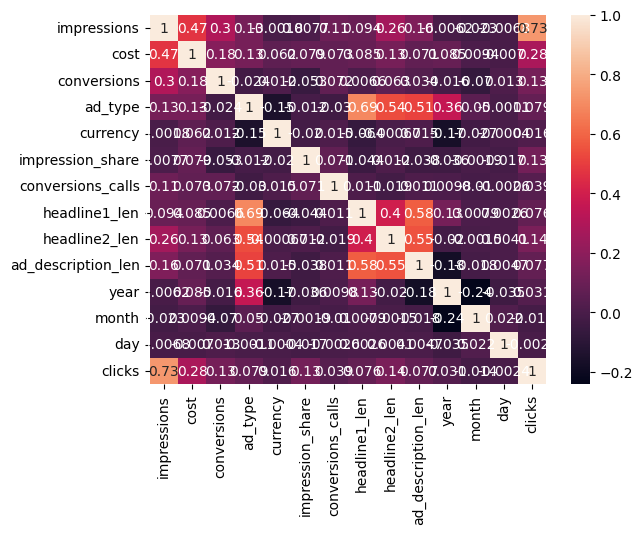

In [9]:
# plot correlation matrix
import seaborn as sns

corr = _prepd_df.corr()

sns.heatmap(corr, annot=True)

In [10]:
# from corr matrix, show features correlation with clicks

corr['clicks'].sort_values(ascending=False)


clicks                1.000000
impressions           0.734686
cost                  0.278872
headline2_len         0.144910
conversions           0.128776
impression_share      0.126332
ad_type               0.079040
ad_description_len    0.077180
headline1_len         0.075684
conversions_calls     0.038814
year                  0.030796
currency              0.016201
day                  -0.002419
month                -0.014417
Name: clicks, dtype: float64

In [18]:
# using the features with correlation > 0.1 from corr['clicks']

corr_features = corr['clicks'][corr['clicks'] > 0.1].index.drop('clicks')

In [19]:
%%capture
x = X[corr_features]
y = df['clicks']

# add date features for time series
x['year'] = X['year']
x['month'] = X['month']
x['day'] = X['day']

In [21]:
x.head()

,impressions,cost,conversions,impression_share,headline2_len,year,month,day
0,142.0,3393.0,0.0,16.279669,5.0,2020,1,1
1,89.0,1817.0,0.0,16.279669,2.0,2020,1,1
2,59.0,1743.0,0.0,16.279669,2.0,2020,1,1
3,78.0,917.0,0.0,16.279669,3.0,2020,1,1
4,20.0,217.0,0.0,16.279669,2.0,2020,1,1


In [22]:
# length check
len(x) == len(y)

True

In [23]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [24]:
# train xgb timeseries
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=3)

In [25]:
# fit model and predict
xgb_reg.fit(x_train, y_train)
xgb_prediction = xgb_reg.predict(x_test)

In [26]:
# model evaluation
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, xgb_prediction)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')

RMSE: 8.057769095659808
MSE: 64.92764279897028


In [32]:
def extract_id_and_date(string):
    parts = string.split('_')
    id_str = parts[1]
    date_str = '_'.join(parts[2:])
    return "ID_" + id_str, pd.to_datetime(date_str, format='%Y_%m_%d')


In [31]:
# submission file
test_df = pd.read_csv('datasets/samplesubmission.csv')

In [33]:
test_df['id'], test_df['date'] = zip(*test_df['ID'].map(extract_id_and_date))
test_df['end_date'] = test_df['date'] + pd.Timedelta(days=6)

In [36]:
test_df.head()

,ID,clicks,id,date,end_date
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0,ID_5da86e71bf5dee4cf5047046,2024-01-22,2024-01-28
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0,ID_5da86e71bf5dee4cf5047046,2024-01-29,2024-02-04
2,ID_5e43c29e6279884e2827d894_2024_02_21,0,ID_5e43c29e6279884e2827d894,2024-02-21,2024-02-27
3,ID_5e43c29e6279884e2827d894_2024_02_28,0,ID_5e43c29e6279884e2827d894,2024-02-28,2024-03-05
4,ID_5e4e7b480e374330ee151305_2023_12_04,0,ID_5e4e7b480e374330ee151305,2023-12-04,2023-12-10


In [91]:
test_row = test_df.iloc[0]
test_row['id']

'ID_5da86e71bf5dee4cf5047046'

In [55]:

XX = X.copy()

In [56]:
XX['date'] = pd.to_datetime(df['date'])

In [85]:
XX['ID'] = df['ID']

In [98]:
XX['id_ID'], XX['date_ignore'] = zip(*XX['ID'].map(extract_id_and_date))

In [ ]:
test_df['id'], test_df['date'] = zip(*test_df['ID'].map(extract_id_and_date))
test_df['end_date'] = test_df['date'] + pd.Timedelta(days=6)

In [99]:
XX.head(3)


,impressions,cost,conversions,ad_type,currency,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,year,month,day,date,ID,id_ID,date_ignore
0,142.0,3393.0,0.0,1,1,16.279669,0.0,2.0,5.0,11.0,2020,1,1,2020-01-01,ID_5da86e71bf5dee4cf5047046,ID_5da86e71bf5dee4cf5047046,NaT
1,89.0,1817.0,0.0,1,1,16.279669,0.0,2.0,2.0,13.0,2020,1,1,2020-01-01,ID_5da86e71bf5dee4cf5047046,ID_5da86e71bf5dee4cf5047046,NaT
2,59.0,1743.0,0.0,1,1,16.279669,0.0,2.0,2.0,10.0,2020,1,1,2020-01-01,ID_5da86e71bf5dee4cf5047046,ID_5da86e71bf5dee4cf5047046,NaT


In [112]:
def filter_df_by_id_and_date_range(id, start_date, end_date):
    """
    Filter DataFrame by ID and date range.

    Args:
    df (DataFrame): Input DataFrame to filter.
    id (str): ID to filter.
    start_date (str or Timestamp): Start date of the range.
    end_date (str or Timestamp): End date of the range.

    Returns:
    DataFrame: Filtered DataFrame containing rows within the specified ID and date range.
    """
    filtered = XX[(XX['ID'] == id) & (XX['date'] >= start_date) & (XX['date'] <= end_date)]
    return filtered[['impressions', 'cost', 'conversions', 'impression_share', 'headline2_len', 'year', 'month', 'day']]

# Assuming 'test_df' is your DataFrame and 'XX' is the DataFrame to filter

# Iterate over each row in test_df
for index, test_row in test_df.iterrows():
    # Filter rows in XX based on the ID and date range from the current row
    filtered_df = filter_df_by_id_and_date_range(test_row['ID'], test_row['date'], test_row['end_date'])

    # Predict clicks for the filtered data
    clicks_predict = xgb_reg.predict(filtered_df)

    # Calculate sum of clicks and update the 'clicks' column in test_df
    test_df.at[index, 'clicks'] = int(np.sum(clicks_predict))

print(test_df)


                                         ID  clicks  \
0    ID_5da86e71bf5dee4cf5047046_2024_01_22       0   
1    ID_5da86e71bf5dee4cf5047046_2024_01_29       0   
2    ID_5e43c29e6279884e2827d894_2024_02_21       0   
3    ID_5e43c29e6279884e2827d894_2024_02_28       0   
4    ID_5e4e7b480e374330ee151305_2023_12_04       0   
..                                      ...     ...   
365  ID_6568807cbb9c4d235c5dd9a8_2024_02_06       0   
366  ID_65a7bf329fa4627faf28390c_2024_02_21       0   
367  ID_65a7bf329fa4627faf28390c_2024_02_28       0   
368  ID_65b0f65c7fe62e56c5593d55_2024_02_21       0   
369  ID_65b0f65c7fe62e56c5593d55_2024_02_28       0   

                              id       date   end_date  
0    ID_5da86e71bf5dee4cf5047046 2024-01-22 2024-01-28  
1    ID_5da86e71bf5dee4cf5047046 2024-01-29 2024-02-04  
2    ID_5e43c29e6279884e2827d894 2024-02-21 2024-02-27  
3    ID_5e43c29e6279884e2827d894 2024-02-28 2024-03-05  
4    ID_5e4e7b480e374330ee151305 2023-12-04 2023-12-10

In [102]:
# count clicks with 0s
test_df[test_df['clicks'] == 0].shape[0]

370

In [103]:
test_df.head()

,ID,clicks,id,date,end_date
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0,ID_5da86e71bf5dee4cf5047046,2024-01-22,2024-01-28
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0,ID_5da86e71bf5dee4cf5047046,2024-01-29,2024-02-04
2,ID_5e43c29e6279884e2827d894_2024_02_21,0,ID_5e43c29e6279884e2827d894,2024-02-21,2024-02-27
3,ID_5e43c29e6279884e2827d894_2024_02_28,0,ID_5e43c29e6279884e2827d894,2024-02-28,2024-03-05
4,ID_5e4e7b480e374330ee151305_2023_12_04,0,ID_5e4e7b480e374330ee151305,2023-12-04,2023-12-10


In [109]:
test_row = test_df.iloc[0]
filtered_df = filter_df_by_date_range(XX, test_row['id'], test_row['date'], test_row['end_date']) 
print(filtered_df)
# clicks_predict = xgb_reg.predict(filtered_df)
np.sum(clicks_predict).astype(int)

Empty DataFrame
Columns: [impressions, cost, conversions, ad_type, currency, impression_share, conversions_calls, headline1_len, headline2_len, ad_description_len, year, month, day, date, ID, id_ID, date_ignore]
Index: []


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date: datetime64[ns], ID: object, id_ID: object, date_ignore: datetime64[ns]